1. Load a cv config with all experiment parameters
2. Load the corresponding data, 
3. create a train and validation generator with the given parameters, exclusive the augmentation parameters
4. reconstruct the model with the given parameters, (we have custom loss functions, simple model.load() will not work)
5. load and apply the corresponding weights (with respect to the distributed training strategy)
6. predict the targt vectors with the train and val generators (make sure that we change the batchsize to 1, and avoid shuffle so that we get all files)
7. unstack each predictions and crop it by the length of the stacked gt mask
8. threshold/argmax each predicted onehot-vector
9. write the gt and predictions as numpy into the corresponding experiment folder (gt with gaussian, or without?, Do we save the onehot or the indicies?)

In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and many other standard libs
# local imports
from src.utils.Notebook_imports import *
from src.utils.Utils_io import Console_and_file_logger, init_config

# import external libs
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import cv2
import pandas as pd
import numpy as np
from ipyfilechooser import FileChooser


search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']


# Load a config into the global namespace

In [6]:
exp_config_chooser = FileChooser(os.path.join(os.getcwd(),'exp/cv_baseline'), '')
display(exp_config_chooser)
@interact_manual
def load_config():

    global exp_config_chooser, config
    """
    load an experiment config
    """
    if 'exp_config_chooser' in globals():
        config_file  = exp_config_chooser.selected
    else:
        print('no config chooser found')

    # load the experiment config
    with open(config_file, encoding='utf-8') as data_file:
        config = json.loads(data_file.read())
    globals().update(config)
    Console_and_file_logger(EXPERIMENT, logging.INFO)
    logging.info('Loaded config for experiment: {}'.format(config['EXPERIMENT']))

FileChooser(path='/mnt/ssd/git/dynamic-cmr-models/exp/cv_baseline', filename='', title='HTML(value='', layout=…

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

# Load the corresponding file names for this fold

In [47]:
# Load SAX volumes
from src.data.Dataset import get_trainings_files
# cluster to local data mapping
#DATA_PATH_SAX = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax'
#DF_FOLDS = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/df_kfold.csv'
#config['DF_META'] = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase'
x_train_sax, y_train_sax, x_val_sax, y_val_sax = get_trainings_files(data_path=DATA_PATH_SAX,
                                                                     path_to_folds_df=DF_FOLDS,
                                                                     fold=FOLD)
logging.info('SAX train CMR: {}, SAX train masks: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('SAX val CMR: {}, SAX val masks: {}'.format(len(x_val_sax), len(y_val_sax)))

2021-05-10 10:22:59,902 INFO no files found, try to load with clean.nrrd/mask.nrrd pattern
2021-05-10 10:22:59,902 INFO searched in: /mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/
2021-05-10 10:22:59,918 INFO Found 278 images/masks in /mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/
2021-05-10 10:22:59,919 INFO Patients train: 210
2021-05-10 10:22:59,930 INFO Selected 209 of 278 files with 210 of 279 patients for training fold 3
2021-05-10 10:22:59,930 INFO SAX train CMR: 209, SAX train masks: 209
2021-05-10 10:22:59,931 INFO SAX val CMR: 69, SAX val masks: 69


# Create the same train and val generators as used for the training

Make sure that:
- no shuffle
- no augmentation (classic and temporal)
- batchsize equal 1

In [48]:
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import PhaseRegressionGenerator
config['SHUFFLE'] = False
config['AUGMENT'] = False
config['AUGMENT_PHASES'] = False
config['BATCHSIZE'] = 1
batch_generator = PhaseRegressionGenerator(x_train_sax, x_train_sax, config=config)
# create another config for the validation data, for the case of different evaluation
val_config = config.copy()
#val_config['AUGMENT'] = False
#val_config['AUGMENT_PHASES'] = False
validation_generator = PhaseRegressionGenerator(x_val_sax, x_val_sax, config=val_config)

2021-05-10 10:23:01,140 INFO Create DataGenerator
2021-05-10 10:23:01,142 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 1
 Scaler: MinMax
 Images: 209 
 Augment: False 
 Thread workers: 8
2021-05-10 10:23:01,142 INFO No augmentation
2021-05-10 10:23:01,164 INFO Smoothing kernel: 
[ 0.1    1.325  2.55   3.775  5.    20.     5.     3.775  2.55   1.325
  0.1  ]
2021-05-10 10:23:01,164 INFO Temporal phase augmentation: 
False
Repeat volume: 
True
2021-05-10 10:23:01,165 INFO Create DataGenerator
2021-05-10 10:23:01,166 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 1
 Scaler: MinMax
 Images: 69 
 Augment: False 
 Thread workers: 8
2021-05-10 10:23:01,166 INFO No augmentation
2021-05-10 10:23:01,180 INFO Smoothing kernel: 
[ 0.1    1.325  2.55   3.775  5.    20.     5.     3.775  2.55   1.325
  0.1  ]
2021-05-10 10:23:01,181 INFO Temporal phase augmentation: 
False
Repeat volume: 
True


# Load the model, load and set the corresponding weights

In [49]:
from src.models.Models import create_PhaseRegressionModel
model = create_PhaseRegressionModel(config)
model.load_weights(os.path.join(config['MODEL_PATH'],'model.h5'))
logging.info('loaded model weights as h5 file')

Shape after the temporal encoder
(None, 36, 8, 4, 4, 320)
Shape after GAP
(None, 36, 320)
Shape after Bi-LSTM layer
(None, 36, 128)
Shape after final conv layer
(None, 36, 5)


2021-05-10 10:23:05,006 INFO loaded model weights as h5 file


# Predict on the validation split

In [50]:
# predict on the validation generator
preds = model.predict(validation_generator)
logging.info(preds.shape)

2021-05-10 10:23:19,461 INFO (69, 2, 36, 5)


# Get all GT vectors

In [51]:
# get all ground truth vectors
gts = np.stack([np.squeeze(y) for x, y in validation_generator])
logging.info(gts.shape)

2021-05-10 10:23:32,599 INFO (69, 2, 36, 5)


# Save gt and pred into the experiment folder

In [52]:
pred_path = os.path.join(config['EXP_PATH'], 'pred')
ensure_dir(pred_path)
pred_filename = os.path.join(pred_path, 'gtpred_fold{}.npy'.format(config['FOLD']))
np.save(pred_filename, np.stack([gts, preds], axis=0))
logging.info('saved as: \n{} \ndone!'.format(pred_filename))

2021-05-10 10:23:32,678 INFO saved as: 
exp/local/baseline_f3/2021-05-07_16_32/pred/gtpred_fold3.npy 
done!


# Load the gts, predictions testwise

In [36]:
temp = np.load(pred_filename)
print(temp.shape)
gts, preds = np.split(temp,indices_or_sections=2)
gts, preds = gts[0], preds[0]
print(gts.shape)
print(preds.shape)

(2, 70, 2, 36, 5)
(70, 2, 36, 5)
(70, 2, 36, 5)


In [37]:
import tensorflow
tensorflow.__version__

'2.3.1'

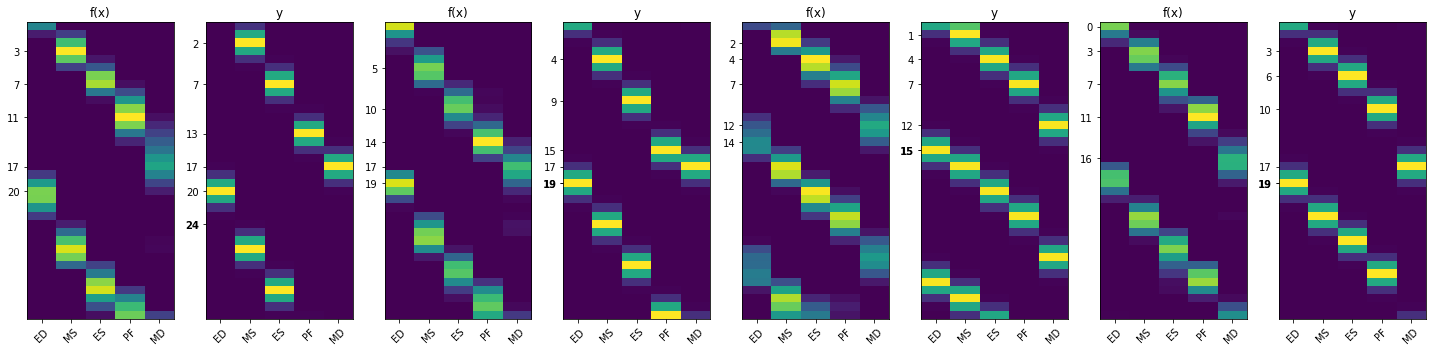

In [40]:
from src.visualization.Visualize import show_phases

_ = show_phases(gts[5:9], preds[5:9])

In [10]:
from src.utils.Metrics import meandiff
res = meandiff(gts,preds, apply_sum=False, apply_average=False)

In [11]:
res.shape

TensorShape([69, 5])

In [12]:
phases = ['ED', 'MS', 'ES', 'PF', 'MD']
df = pd.DataFrame(res.numpy(), columns=phases)
df.shape

(69, 5)

In [13]:
df

,ED,MS,ES,PF,MD
0,0,0,2,1,1
1,1,1,0,2,2
2,1,1,2,0,1
3,1,1,1,1,1
4,0,0,1,0,0
...,...,...,...,...,...
64,1,2,3,1,0
65,1,1,1,0,2
66,1,1,1,0,0
67,2,0,0,1,1
